## DynamoDB Intro Workbook ##

This workbook will walk through the basics of getting started on DynamoDB. It is intended to demostrate the API building blocks that can then be combined for complex modeling (in subsequent labs). This lab uses Python 3 and the native DynamoDB SDK. All the client setup and code samples are demostrated and interactive.  

<em>The AWS Boto3 SDK is pre-installed and a role with permissions to create and modify DynamoDB resources has been assigned to this instance. If you are running this on another Jupyter notebook you may need to install boto3 and configure permissions (instructions can be found in the README.</em>  

Let's get started! 

DynamoDB is a fast serverless scalable key-value and document database hosted on AWS.

The basic functional abstraction of DynamoDB is a Table. Data is organzed on a table with an index, which is required on all tables. An index can be a simple primary key, which consists of a partition key <em>(used for 1:1 modeling of key-value data)</em>. Or a composite primary key, which is created using partition and sort key <em>(used for 1:n modeling of parent-child relationships and related data)</em>.

Update the 'Name' value in the cell below with your initials. This is going to be the table name that you are working with. While the cell below is active, click 'Run' to initialize the DynamoDB client and import the JSON library. <em> If at any point in the Lab you disconnect, you may need to rerun this cell to reactivate the client. </em>

In [ ]:
import boto3 # <----- This is the Python SDK to interact with DynamoDB
import json

Name='initialshereXX-RecipeTable'

# Set up the DynamoDB client (a low level API). All requests are HTTPS requests by default. 
client = boto3.client('dynamodb', region_name = 'us-east-1')
print('\n DynamoDB client is now active. \n')

So, let's create our first table. The code below specifies the base table index attributes and table name. While the below cell is active, select 'Run.'

It is going to take a minute to complete the creation of the new table. While it is pending, let's take a look at the code. You will notice that there are a couple important variables:  
1. Table Name: this must be unique within a region by account.
2. Key Schema: in the below example this is composite key with the partition (or HASH) key as RecipeName and the sort (or RANGE) key as Ingredients. You will notices that both are of AttributeType 'S' that means both are strings.

In [ ]:
print('Submitting table creation request... this may take a minute or two. When it completes, it will print details below... \n')

# Create the DynamoDB table.
response = client.create_table(
    TableName=Name, # <----- This is the table name from above
    KeySchema=[
        {
            'AttributeName': 'RecipeName', # <----- This is the Partition Key
            'KeyType': 'HASH' # <----- It is also referred to as the Hash key, because DynamoDB uses it to hash the keys internally.
        },
        {
            'AttributeName': 'Ingredients', # <----- This is the Sort Key
            'KeyType': 'RANGE' # <----- It is also referred to as a Range key, because it supports range queries.
        }
    ],
    AttributeDefinitions=[
        {
            'AttributeName': 'RecipeName',
            'AttributeType': 'S'
        },
        {
            'AttributeName': 'Ingredients',
            'AttributeType': 'S'
        },
    ],
    BillingMode= 'PAY_PER_REQUEST' # <----- We'll tackle this with an understanding capacity planning section
)

# Wait until the table exists.
client.get_waiter('table_exists').wait(TableName=Name)

# Print out detailed data about the new table.
response = client.describe_table(TableName=Name)

print(json.dumps(response, indent=1, default=str))
print("Table is active... \n")


Now, what did we just do? We created our first DynamoDB table called YourInitials-Recipes.  

We set the partition key to the Recipe Name and the sort key to the ingredients. While it doesn't have data yet, this table could look like:  

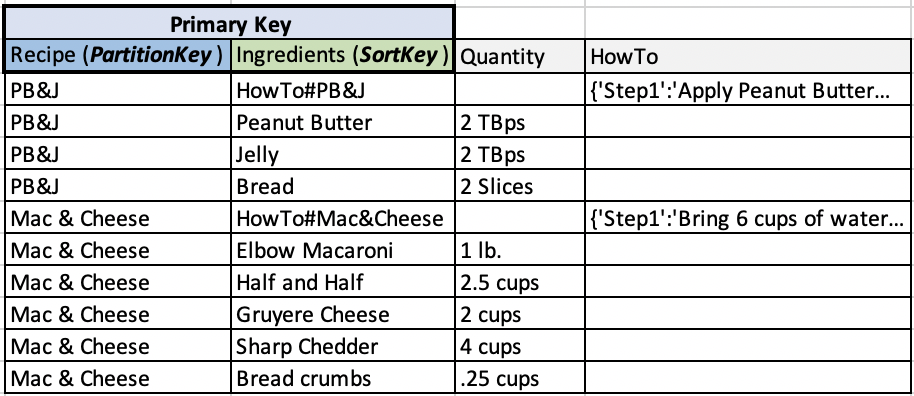  

We chose Recipe as the partition key because we are going to build the backend of an online cooking application where we track all of the best recipes. Recipe names are the natural way to organize the data based on an application retrieval pattern of getting recipes by name. Names also provide high cardinality and reasonably even distribution of access, which adheres to DynamoDB best practices when choosing a partition key ([Best practices](https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/bp-partition-key-design.html "DynamoDB Best Partices")). The ingredients make a natural sort key, because they are the related elements of a recipe. 

If you are familiar with relational databases, you may wonder - <em> 'won't I have duplicate ingredients across recipes?'</em> or <em>'shouldn't ingredients have their own table?' </em> You have identified a fundamental difference between relational and NoSQL data models. With NoSQL design, items are denormalized into prebuilt aggregates that are optimal for reads and use minimal CPU overhead to retrieve data. This design enables a database like DynamoDB to horizontally scale and serve millions of requests per second without impacting performance. In the above example, we can very efficiently retrieve all the related items of a single recipe rather than joining across a recipes table, an instructions table, and an ingredients table... but we are getting ahead of ourselves.

Let's put some data into the table to see what it looks like!

We are going to load a recipe instruction record, or 'How To.' These are the instructions of the recipe. This item (or row) will have a partition key matching the recipe name, but the sort key will simply be "HowTo#RecipeName." We then can programmatically retrieve the instructions for any recipe we upload by using the recipe name and the known pattern of the sort key. 
  
Inspect the below code and click 'Run' to insert the instructions for Egg Nog (a festive favorite)!

In [ ]:
response = client.put_item(
    TableName=Name, # <---- this is the same table we created above
    Item={
        'RecipeName': {
            'S': 'Egg Nog'
        },
        'Ingredients': {
            'S': 'HowTo#Egg Nog'
        },
        'HowTo': {
            'S': 'Blend together eggs, sugar, milk, vanilla and nutmeg. Serve chilled.\n'
        }
    },
    ReturnConsumedCapacity='TOTAL'
)
print(json.dumps(response, indent=1, default=str) + "\n")

Great! We can see by the HTTPStatusCode: 200 that this was successful! We just inserted this item:

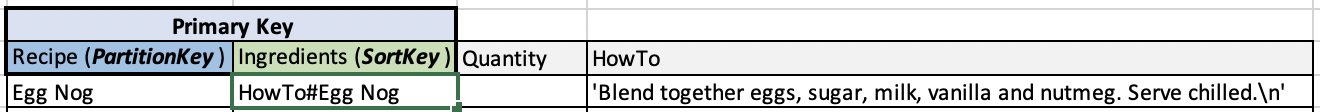  

We can even see that this request consumed 1 CapacityUnit. We will discuss that more later, but is important to understand that DynamoDB measures the usage based on reads and writes per second by object size. 

Let's go ahead and insert each of the ingredients related to the recipe. We can use a BatchWriteItem API to insert many items at once (up to a maximum of 25 items). 

We've left the last item generic - so you can add your own twist to the Egg Nog recipe. Update the last item in the code below, and when you're ready click 'Run.'

In [ ]:
response = client.batch_write_item(
    RequestItems={
        Name : [ # <---- this indicates we are using the same table we created above
            {
                'PutRequest': { # <---- Each of these is an ingredient to insert. BWI also supports DeleteRequest.
                    'Item': {
                        'RecipeName': {
                        'S': 'Egg Nog' # <---- Partition Key 
                        },
                        'Ingredients': {
                            'S': 'Eggs'  # <---- Sort Key: Ingredient associated with Egg Nog (1:n relationship)
                        },
                        'Quantity': {
                            'S': '2'
                        },                        
                    }
                }
            }   
            ,
            {
                'PutRequest': {
                    'Item': {
                        'RecipeName': {
                        'S': 'Egg Nog'
                        },
                        'Ingredients': {
                            'S': 'Sugar' 
                        },
                        'Quantity': {
                            'S': '3 TBsp'
                        },                        
                    }
                }
            },
            {
                'PutRequest': {
                    'Item': {
                        'RecipeName': {
                        'S': 'Egg Nog'
                        },
                        'Ingredients': {
                            'S': 'Milk' 
                        },
                        'Quantity': {
                            'S': '2 1/3 cups'
                        },                        
                    }
                }
            },
            {
                'PutRequest': {
                    'Item': {
                        'RecipeName': {
                        'S': 'Egg Nog'
                        },
                        'Ingredients': {
                            'S': 'Vanilla Extract' 
                        },
                        'Quantity': {
                            'S': '1 tsp'
                        },                        
                    }
                }
            },
            {
                'PutRequest': {
                    'Item': {
                        'RecipeName': {
                        'S': 'Egg Nog'
                        },
                        'Ingredients': {
                            'S': 'Nutmeg' 
                        },
                        'Quantity': {
                            'S': '1 dash'
                        },                        
                    }
                }
            },
            {
                'PutRequest': {
                    'Item': {
                        'RecipeName': {
                        'S': 'Egg Nog'
                        },
                        'Ingredients': {
                            'S': 'IngredientName' # <---- ** Your ingredient here **
                        },
                        'Quantity': {
                            'S': 'IngredientQuantity' # <---- ** Quantity of the ingredient here **
                        },                        
                    }
                }
            }]
            },
    ReturnConsumedCapacity='TOTAL'
    )
                

print(json.dumps(response, indent=1, default=str) + "\n")

Great - we inserted all the ingredients as a single request! Did you see that the ConsumedCapacity was higher as we added many items simultaneously?

Our table should now look like :  
<em>(plus your ingredient)</em>

  
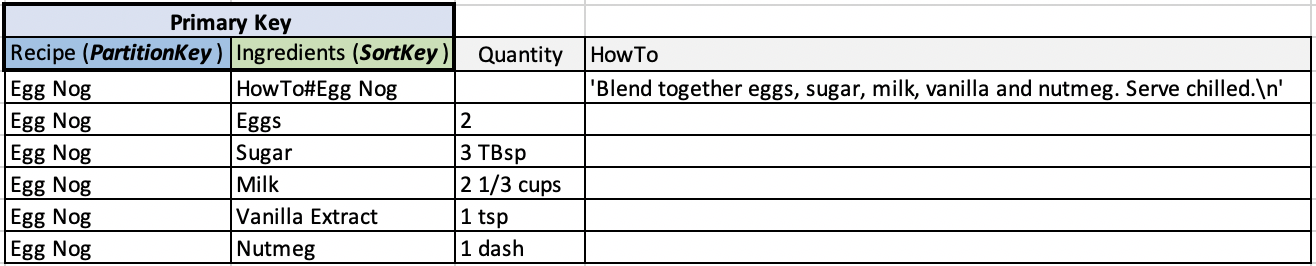
 

You may notice that not all the items conform to the same schema. There is also no limitation on adding different types of items <em>(Ingredients and HowTo's)</em> to the index as long as each item adhers to the data type (String) of the index we specified at table creation. 


Let's take a look at our table to see what it looks like in realtime. <em>You can come back and run this at any time during the lab.</em>

The Scan API will retrieve all the items on a table. It can paginate through the items and return them in responses that are up to 1MB. Scans can be filtered on conditions and limited by item count. It is a good way for us to validate our work. In general, Scans are not used as part of an application design because they can consume many read units and under-perform compared to the targeted retrieval APIs GETs or QUERIES. DynamoDB workloads tend to be transactional in nature, which enables very specific data retrieval not broad table scans.

Run the following cell to scan the current table...

In [ ]:
import pandas as pd  # < -- Let's use Pandas & HTML to make the scan response more human readable
from IPython.core.display import HTML

response = client.scan( # < -- Scan request. Note it will return a max of 10 items.
    TableName=Name,
    Limit=10,
    ReturnConsumedCapacity='TOTAL')

# ** Pandas tranformation of response to a table and render it as HTML ** #
dataMap = json.loads(json.dumps(response))['Items']
HTML(pd.DataFrame(dataMap, columns=["RecipeName", "Ingredients", "Quantity", "HowTo"]).style.render().replace('nan',''))


Did you notice how each item contains the attribute type as well as the value? So far we've only added strings.

In [ ]:
#Run this cell to see the actual reponse from the scan. This is what your application will parse and use.

print(json.dumps(response, indent=1, default=str) + "\n")

What if the author of this recipe decided that they want to change the instructions? They could either use the PutItem API above to overwrite the item with a new item. Or, they could use the UpdateItem API to simply update the existing attribute "HowTo."